# Variational AutoEncoder


### load image

Image is from CeleA.

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import time

import skimage.io as img_io
import numpy as np

from matplotlib import pyplot as plt

import tensorflow as tf

gpu_opt = tf.ConfigProto(gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5 , allow_growth=True) 
                             ,device_count={'GPU': 1})
ly = tf.contrib.layers

/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_root = "data"
train_path = os.path.join( data_root , "train" )
test_path = os.path.join( data_root , "test" )

train_attribute = np.genfromtxt( train_path+".csv" , delimiter="," , skip_header=0 , dtype="str")
test_attribute = np.genfromtxt( test_path+".csv" , delimiter="," , skip_header=0 , dtype="str")


attr = train_attribute[0,1::]
print("Attribute : ")
print(" , ".join(attr[1:8]))
print(" , ".join(attr[8::]))



Attribute : 
Big_Lips , Black_Hair , Blond_Hair , Brown_Hair , Heavy_Makeup , High_Cheekbones , Male
Mouth_Slightly_Open , Smiling , Straight_Hair , Wavy_Hair , Wearing_Lipstick


In [3]:
train_id = train_attribute[1:,0]
train_attribute = train_attribute[1:,1::].astype("float")

test_id = test_attribute[1:,0]
test_attribute = test_attribute[1:,1::].astype("float")


In [4]:
## load image
train_img = []
for f in train_id:
    train_img.append( img_io.imread( os.path.join( train_path , f ) ) )
    

test_img = []
for f in test_id:
    test_img.append( img_io.imread( os.path.join( test_path , f ) ) )

train_img = np.array(train_img).astype("float")
test_img = np.array(test_img).astype("float")
    


print("Shape of training data :" , train_img.shape)
print("Shape of testing data  :" , test_img.shape)

Shape of training data : (40000, 64, 64, 3)
Shape of testing data  : (2621, 64, 64, 3)


In [5]:
len(os.listdir(test_path))

2621

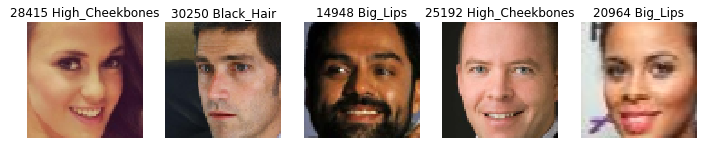

In [6]:
k = 5
idx = np.random.choice(40000 , size=k)

fig = plt.figure(figsize=(2*k+2,3))
for i,img_name in enumerate( idx ):
    ax = fig.add_subplot( 1,k , i+1 )
    ax.imshow( train_img[img_name].astype("int") )
    ax.axis("off")
    a = np.argmax(train_attribute[img_name])
    
    ax.set_title(str(img_name)+" "+attr[a])
plt.show()


In [7]:
processing_input = lambda x : (x/255-0.5)*2
inverse_processing = lambda x : (x/2+0.5)*255

In [8]:
train_data = processing_input(train_img)

test_data = processing_input(test_img)

### Build Model

In [9]:
tf.reset_default_graph()
VAE_graph = tf.Graph()

In [10]:
def reconstruct_layer(inputs , tr=True):
    x = ly.fully_connected(inputs , 2048 , trainable=tr 
                            , scope="fc_1")
    x = tf.reshape( x , shape=[-1,1,1,2048] )

    x = ly.conv2d_transpose(x , 512 , [2,2] , padding="VALID" , trainable=tr
                             , scope="Conv2DT_1")
    x = ly.conv2d_transpose(x , 256 , [5,5] , padding="VALID" , trainable=tr
                             , scope="Conv2DT_2")
    x = ly.batch_norm(x  , trainable=tr , scope="bc_1")
    x = ly.conv2d_transpose(x , 128 , [6,6] , stride=[2,2] , padding="VALID" 
                            , trainable=tr , scope="Conv2DT_3")

    x = ly.batch_norm(x , reuse=tf.AUTO_REUSE , scope="bc_2")
    x = ly.conv2d_transpose(x , 64 , [9,9] , stride=[4,4] , padding="SAME" 
                            , trainable=tr  , scope="Conv2DT_4")

    out = ly.conv2d(x , 3 , [1,1] , padding="VALID" , activation_fn=tf.nn.tanh 
                    , trainable=tr  , scope="To_rgb")
    return out
        

In [11]:
with VAE_graph.as_default():
    latent_dim = 1024
    
    with tf.name_scope("Input"):
        img = tf.placeholder( shape=[None , 64,64,3] , dtype=tf.float32 )
    
    with tf.name_scope("Encode"):
        with tf.name_scope("block1"):
            _ = ly.conv2d( img , 64 , [5,5] , padding="VALID" )
            _ = ly.conv2d( _ , 96 , [3,3] , padding="VALID" )
            block_1 = ly.avg_pool2d( _ , [3,3] , stride=[2,2] , padding="VALID" )
            
        with tf.name_scope("block2"):
            _ = ly.batch_norm(block_1)
            _ = ly.conv2d( _ , 96 , [3,3] , padding="VALID" )
            _ = ly.conv2d( _ , 128 , [3,3] , padding="VALID" )
            block_2 = ly.max_pool2d( _ , [3,3] , stride=[2,2] , padding="VALID" )
            
        with tf.name_scope("block3"):
            _ = ly.batch_norm(block_2)
            _ = ly.conv2d( _ , 128 , [3,3] , padding="VALID" )
            _ = ly.conv2d( _ , 256 , [1,1] , padding="VALID" )
            _ = ly.conv2d( _ , 256 , [3,3] , padding="VALID" )
            block_3 = ly.avg_pool2d( _ , [2,2] , stride=[1,1] , padding="VALID" )
        
        with tf.name_scope("block4"):
            _ = ly.batch_norm(block_3)
            _ = ly.conv2d( _ , 512 , [3,3] , stride=[2,2] , padding="VALID" )
            block_4 = ly.conv2d( _ , 2048 , [2,2] , padding="VALID" )
        
        flat_code = tf.reshape( block_4 , shape=[-1,2048] , name="flat")
        
    with tf.name_scope("z_code"):
        z_mean = ly.fully_connected(flat_code , latent_dim , activation_fn=tf.nn.tanh , scope="z_mean")
        z_log_var = ly.fully_connected(flat_code , latent_dim , activation_fn=tf.nn.leaky_relu , scope="z_log_var")
    
    with tf.name_scope("Sampling"):
        epsi = tf.random_normal( shape=tf.shape(z_log_var) )
        z = z_mean + epsi*tf.exp(z_log_var/2)

    with tf.name_scope("Decode"):
        with tf.variable_scope("shared_decoder"):
            img_reconstruct = reconstruct_layer(z)
    
    
    with tf.name_scope("Infer"):
        with tf.variable_scope("shared_decoder" , reuse=True):
            Infer_img = reconstruct_layer(z_mean , tr=False )
            Infer_loss = tf.reduce_mean( tf.square(Infer_img-img ))
    ## Assign random vector to z 
    with tf.name_scope("random_infer"):
        with tf.variable_scope("shared_decoder" , reuse=True):
            random_z = tf.placeholder(shape=[None,latent_dim] , dtype=tf.float32)
            Infer_by_random = reconstruct_layer(random_z , tr=False)
            
    
    with tf.name_scope("Loss"):
        with tf.name_scope("KL_loss"):
            kl_loss = -0.5*tf.reduce_sum( 1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var) ,axis=-1 )
            
            
        with tf.name_scope("MSE_loss"):
            dim = 1
            for d in img.shape[1::]:
                dim *= int(d)
            mse_loss = tf.reduce_mean(  tf.reshape(tf.square(img - img_reconstruct) , [-1,dim]),axis=-1)
            
    
        loss = tf.reduce_mean(mse_loss+5e-5*kl_loss)
    tf.summary.scalar("Loss/KL_loss" , tf.reduce_mean(kl_loss))  
    tf.summary.scalar("Loss/MSE_loss" , tf.reduce_mean(mse_loss))
    tf.summary.scalar("Total_loss" , loss)
    
    with tf.name_scope("Train_strategy"):
        decay_policy = tf.train.exponential_decay(2e-4 , decay_rate=0.9 , decay_steps=4000 , global_step=1000)
        opt_operation = tf.train.AdamOptimizer(learning_rate=decay_policy).minimize(loss)
        
        second_opt_operation = tf.train.AdamOptimizer(1e-6).minimize(loss)
    
    init = tf.global_variables_initializer()
    
#     merged_log = tf.summary.merge_all()
#     VAE_writer = tf.summary.FileWriter("tb_logs/VAE_ver0" , graph=VAE_graph)
    
    saver = tf.train.Saver()
    
        

In [12]:
sess = tf.Session(graph=VAE_graph , config=gpu_opt)
sess.run( init )

In [ ]:
n_epoch = 500
n_batch = 200

n_step = train_data.shape[0]//n_batch
# s = 0
r_index = np.arange( train_data.shape[0] )
history = []
step_kl_loss = []
step_xmse_loss = []
for e in range(n_epoch):
    start_time = time.time()
    np.random.shuffle( r_index )
    data_x = train_data[r_index]
    start = 0
    print( "Epoch {0:4d}/{1}".format( e+1 , n_epoch ) )
    l_e = 0
    for step in range(n_step):
        print( "[{0:-<30}]".format( "="*((step+1)*30//n_batch) ) , end="\r" )
        data_config = { img:data_x[start:start+n_batch]}
        s+=1
        summary , l , _ = sess.run([ merged_log , loss , opt_operation ], feed_dict=data_config )
        if (s%10) ==0 :
            VAE_writer.add_summary(summary , s)
        l_e += l*n_batch/train_data.shape[0]
        
        start+=n_batch
        
    
    print("[{0:-<30}] loss: {1:.5f}  time: {2:.1f}".format( "="*((step+1)*30//n_batch) , l_e , time.time()-start_time))
        
    

Epoch    1/500
[==============================] loss: 0.02106  time: 55.0
Epoch    2/500
[==============================] loss: 0.02108  time: 34.9
Epoch    3/500
[==============================] loss: 0.02101  time: 34.9
Epoch    4/500
[==============================] loss: 0.02102  time: 34.4
Epoch    5/500
[==============================] loss: 0.02096  time: 34.4
Epoch    6/500
[==============================] loss: 0.02098  time: 34.4
Epoch    7/500
[==============================] loss: 0.02093  time: 34.4
Epoch    8/500
[==============================] loss: 0.02101  time: 34.4
Epoch    9/500
[==============================] loss: 0.02097  time: 34.4
Epoch   10/500
[==============================] loss: 0.02092  time: 34.4
Epoch   11/500
[==============================] loss: 0.02093  time: 34.5
Epoch   12/500
[==============================] loss: 0.02095  time: 34.4
Epoch   13/500
[==============================] loss: 0.02090  time: 34.4
Epoch   14/500
[======================

Epoch  112/500
[==============================] loss: 0.02028  time: 34.3
Epoch  113/500
[==============================] loss: 0.02025  time: 34.3
Epoch  114/500
[==============================] loss: 0.02026  time: 34.3
Epoch  115/500
[==============================] loss: 0.02030  time: 34.3
Epoch  116/500
[==============================] loss: 0.02028  time: 34.3
Epoch  117/500
[==============================] loss: 0.02030  time: 34.3
Epoch  118/500
[==============================] loss: 0.02027  time: 34.3
Epoch  119/500
[==============================] loss: 0.02025  time: 34.3
Epoch  120/500
[==============================] loss: 0.02022  time: 34.3
Epoch  121/500
[==============================] loss: 0.02026  time: 34.3
Epoch  122/500
[==============================] loss: 0.02023  time: 34.3
Epoch  123/500
[==============================] loss: 0.02018  time: 34.4
Epoch  124/500
[==============================] loss: 0.02023  time: 34.4
Epoch  125/500
[======================

In [44]:
# saver.save(sess,"model_para/VAE-ver0")

'model_para/VAE-ver0'

In [29]:
i = 10
test1 = sess.run( Infer_img , feed_dict={img:train_data[i:i+2]} )
test1 = inverse_processing(test1)

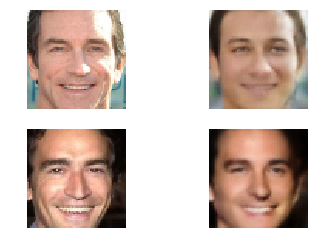

In [30]:
fig , ((ax1 , ax2) ,( ax3 , ax4)) = plt.subplots(2,2)

ax1.imshow(train_img[i].astype("int"))
ax1.axis("off")

ax2.imshow(test1[0].reshape(64,64,3).astype("int"))
ax2.axis("off")

ax3.imshow(train_img[i+1].astype("int"))
ax3.axis("off")

ax4.imshow(test1[1].reshape(64,64,3).astype("int"))
ax4.axis("off")

plt.show()

In [14]:
def concat_img(g , col=10):
    concat_all_img = []
    img_count = g.shape[0]
    row_padding = np.zeros(shape=[1 , g.shape[2]*col+col-1,3])
    col_padding = np.zeros(shape=[g.shape[1],1,3])
    for i in range(img_count//col):
        a = g[i*col]
        for j in range(1,col):
            a = np.concatenate( [ a , col_padding , g[ i*col+j ]  ] , axis=1  )
        concat_all_img.append(a)
        if i == (img_count//col-1):
            break
        concat_all_img.append(row_padding)
    return np.concatenate( concat_all_img , axis=0 )

In [13]:
saver.restore(sess , "model_para/VAE-ver0")

INFO:tensorflow:Restoring parameters from model_para/VAE-ver0


In [97]:
pr_img_path = "tmp/{}".format("VAE-ver0")
if not os.path.exists(pr_img_path):
    os.mkdir(pr_img_path)
print(pr_img_path)

tmp/VAE-ver0


In [ ]:
# idx = np.round(np.random.sample(10)*test_img.shape[0]).astype("int")

In [101]:
idx = [2314,402,1111,399,41,2169,432,683,218,2455]

array([2314,  402, 1111,  399,   41, 2169,  432,  683,  218, 2455])

In [103]:
print(",".join(idx.astype("str")))

2314,402,1111,399,41,2169,432,683,218,2455


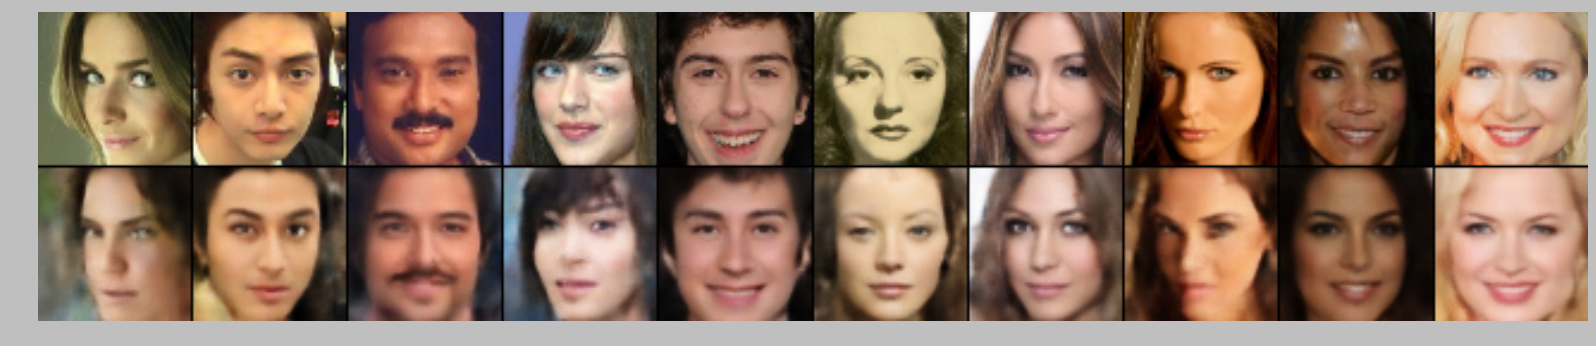

In [141]:
plt.style.use("classic")

test_reconstruct = sess.run(Infer_img , feed_dict={img:test_data[idx]})

test_reconstruct = np.concatenate([test_img[idx] , inverse_processing(test_reconstruct)] , axis=0)

plt.figure(figsize=(25,5))
plt.imshow(concat_img(test_reconstruct).astype("int"))
plt.axis("off")
plt.savefig("tmp/{}/fig1_3.png".format("VAE-ver0"))


In [86]:
start = 0
l = 0
batch_size=100
for l in range(test_data.shape[0]//batch_size):
    l += sess.run(Infer_loss , feed_dict={img:test_data[start:start+batch_size]})
    start+=batch_size
l += sess.run(Infer_loss , feed_dict={img:test_data[start:start+batch_size]})


print("MSE of test image :" , l*100/test_data.shape[0])

MSE of test image : 0.9583640424339246


In [111]:
batch_z = np.random.randn(32,latent_dim)
np.save("{}/random_z.npy".format(pr_img_path) , batch_z)

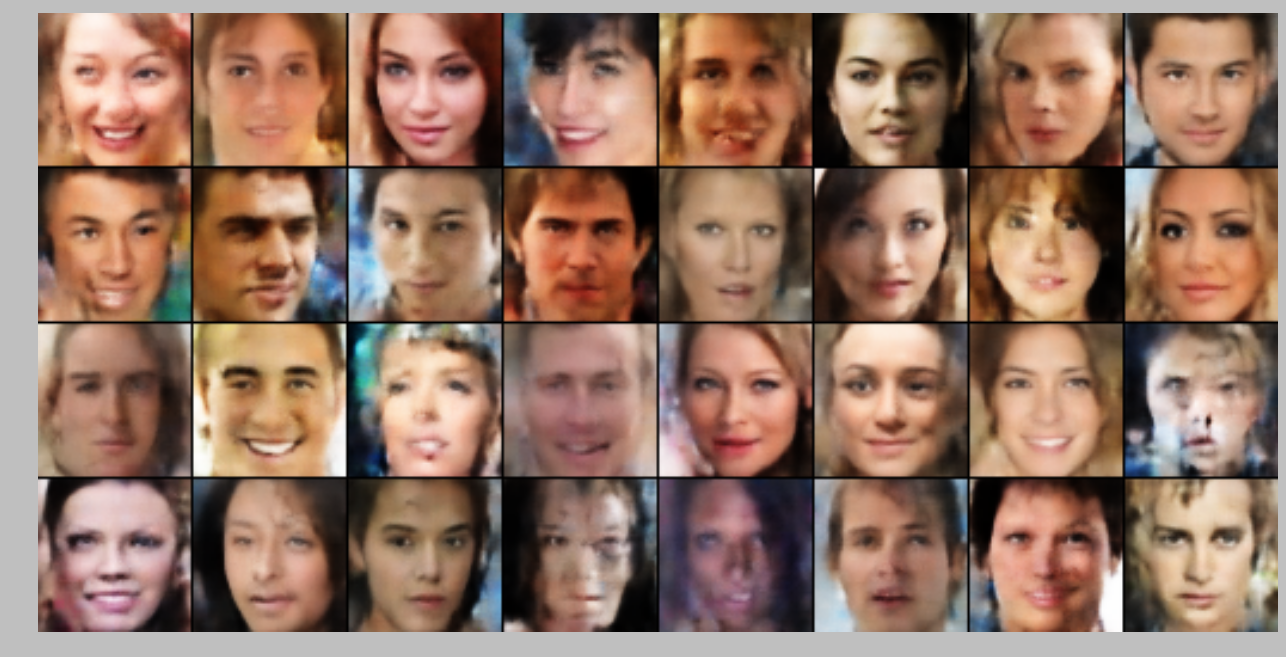

In [142]:
random_reconstruct = sess.run( Infer_by_random , feed_dict={random_z:batch_z} )
random_reconstruct = inverse_processing(random_reconstruct)
random_reconstruct = concat_img(random_reconstruct , col=8)

plt.figure(figsize=[20,12])
plt.imshow(random_reconstruct.astype("int"))
plt.axis("off")
plt.savefig("{}/fig1_4.png".format(pr_img_path))
plt.show()

In [15]:
from sklearn.manifold import TSNE

In [16]:
start = 0
test_latent_space = []
batch_size=100
for l in range(test_data.shape[0]//batch_size):
    test_latent_space.append( sess.run(z_mean , feed_dict={img:test_data[start:start+batch_size]}))
    start+=batch_size
test_latent_space.append(sess.run(z_mean , feed_dict={img:test_data[start:start+batch_size]}))

test_latent_space = np.concatenate(test_latent_space , axis=0)

In [17]:
reduction_z = TSNE(random_state=1).fit_transform(test_latent_space)

In [125]:
attr

array(['Bangs', 'Big_Lips', 'Black_Hair', 'Blond_Hair', 'Brown_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Lipstick'],
      dtype='<U19')

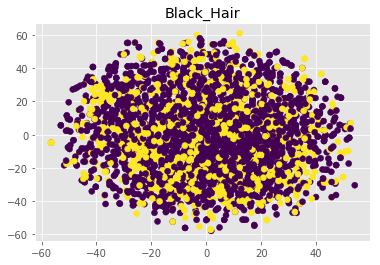

In [136]:
i = 2
test_attr = test_attribute[:,i:i+1]
plt.style.use("ggplot")
plt.title(attr[i])
plt.scatter(reduction_z[:,0],reduction_z[:,1] , c=test_attr[:,0])
plt.savefig("{}/fig1_5.png".format(pr_img_path))
plt.show()

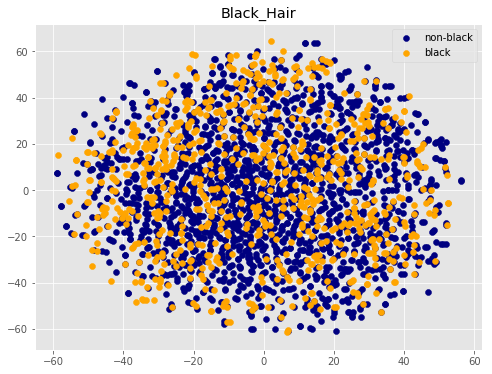

In [40]:
i = 2
test_attr = test_attribute[:,i:i+1]
plt.style.use("ggplot")

# plt.figure(figsize=[8,6])
fig, ax = plt.subplots(figsize=[8,6])
plt.title(attr[i])
label = ["non-black" , "black"]
color = ["navy" , "orange" ]
for i in range(2):
    idx = test_attr.reshape(-1)==i
    ax.scatter(reduction_z[idx,0],reduction_z[idx,1] , c=color[i] , label=label[i])
# plt.savefig("{}/fig1_5.png".format(sys.argv[2]))
plt.legend()
plt.show()

In [46]:
idx = np.random.choice(np.arange(test_data.shape[0]) , size=1500 , replace=False)

In [47]:
np.save("{}/sample_test_data_idx.npy".format("tmp/VAE-ver0") , idx)

In [18]:
i = 2
test_attr = test_attribute[:,i:i+1]

In [25]:
idx = test_attr==1

In [26]:
reduction_z[idx.reshape(-1),0]

array([-1.33448191e+01, -4.23372841e+01,  5.12123585e+00,  5.55870104e+00,
       -4.20930786e+01,  1.97008801e+00,  2.51215839e+00,  4.91292620e+00,
       -1.04081831e+01, -1.22616615e+01,  1.48431807e+01,  3.76280670e+01,
       -3.31438994e+00,  6.64142275e+00,  1.00914049e+01, -3.30278549e+01,
       -8.41525078e+00, -1.55760202e+01, -5.41914177e+01, -1.66822491e+01,
       -3.92252998e+01, -3.18324661e+01, -2.11521378e+01, -1.04512272e+01,
       -3.31279945e+01, -3.33280258e+01,  5.24688416e+01, -2.98874741e+01,
       -3.64834061e+01, -2.79427910e+01, -3.20002174e+01,  2.65114117e+01,
       -3.41042519e+01,  4.95916083e-02,  1.11325560e+01, -2.86780090e+01,
       -2.91382008e+01, -4.70566216e+01,  2.28219547e+01, -2.63140869e+01,
        4.63268089e+01, -3.88069496e+01, -2.33340187e+01, -1.09026690e+01,
        2.21490231e+01, -2.39034252e+01,  1.67562389e+01,  5.41212273e+00,
       -2.24694691e+01, -9.49550629e+00,  2.17626762e+01, -4.20687866e+01,
       -1.84427090e+01, -

False